In [40]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import requests
import feather
from pytrends.request import TrendReq
import pytrends
import pickle
from multiprocessing import Pool
import seaborn as sns

In [41]:
!ls

Aggregate Statistics and clean Data from FBReference.ipynb
Cleaned Up Scrape of Goals and Height.ipynb
Combine Fifa with Big Dataset.ipynb
EDA.ipynb
Notebook for fifa stats.ipynb
README.md
Untitled.ipynb
database.sqlite
df_15_16_17_18_in_goals_apps.feather
df_FBRefStatistics.feather
df_Performance.feather
fbref_csvs
fifa-18-demo-player-dataset.zip
fifa_16
fifa_17
fifa_18
fifa_19
fifa_df.feather
figures
keep_columns.txt
llooking at correlations.ipynb
performance_csvs
py_trends.ipynb
src
transfer_data


In [42]:
df_performance = feather.read_dataframe("df_Performance.feather")

/Users/sethweiland/anaconda3/envs/DS_env/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [72]:
df_performance.shape

(1192, 9)

In [44]:
df_performance = df_performance.set_index("Season_Transfer")

In [45]:
df_performance = df_performance.drop(["fee_normal","height", "Starts", "Subs", "Min", "Mn/Ap", "PK", "PKatt", "CrdY"],axis=1) 

In [46]:
df_performance.head()

,age,fee_cleaned,year,Apps,Gls,Ast,Fls,CrdR,SoT
Season_Transfer,,,,,,,,,
Davy_Pröpper 2015-16,23.0,4.05,2015.0,30.0,5.0,4.0,74.0,1.0,23.0
Ryad_Boudebouz 2015-16,25.0,1.53,2015.0,34.0,5.0,3.0,42.0,0.0,12.0
Kévin_Théophile-Catherine 2015-16,25.0,1.80,2015.0,31.0,0.0,0.0,43.0,0.0,1.0
Raúl_Jiménez 2015-16,24.0,19.80,2015.0,21.0,1.0,2.0,14.0,0.0,11.0
Karim_Rekik 2015-16,20.0,4.50,2015.0,26.0,2.0,2.0,27.0,0.0,2.0


In [47]:
fees = np.array(df_performance["fee_cleaned"].sort_values(ascending=True))
log_fees = np.log(fees)

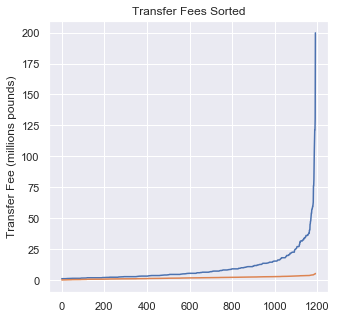

In [48]:
plt.figure(figsize=(5,5))
plt.plot(fees)
plt.plot(log_fees)
plt.ylabel("Transfer Fee (millions pounds)")
plt.title("Transfer Fees Sorted");

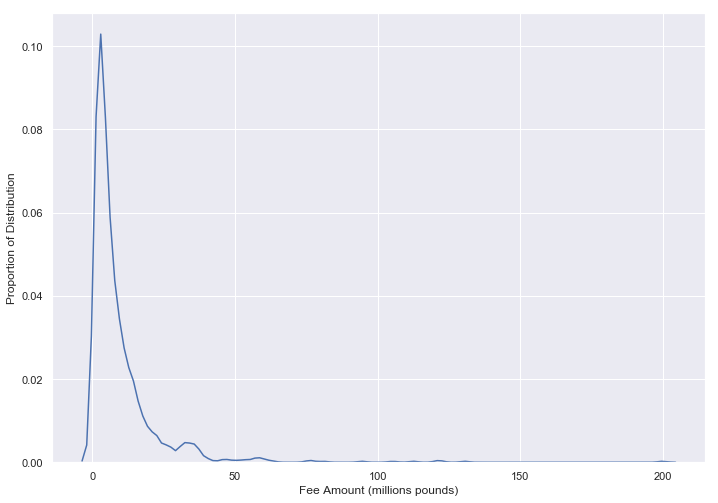

In [49]:
sns.kdeplot(fees)
plt.xlabel("Fee Amount (millions pounds)")
plt.ylabel("Proportion of Distribution");

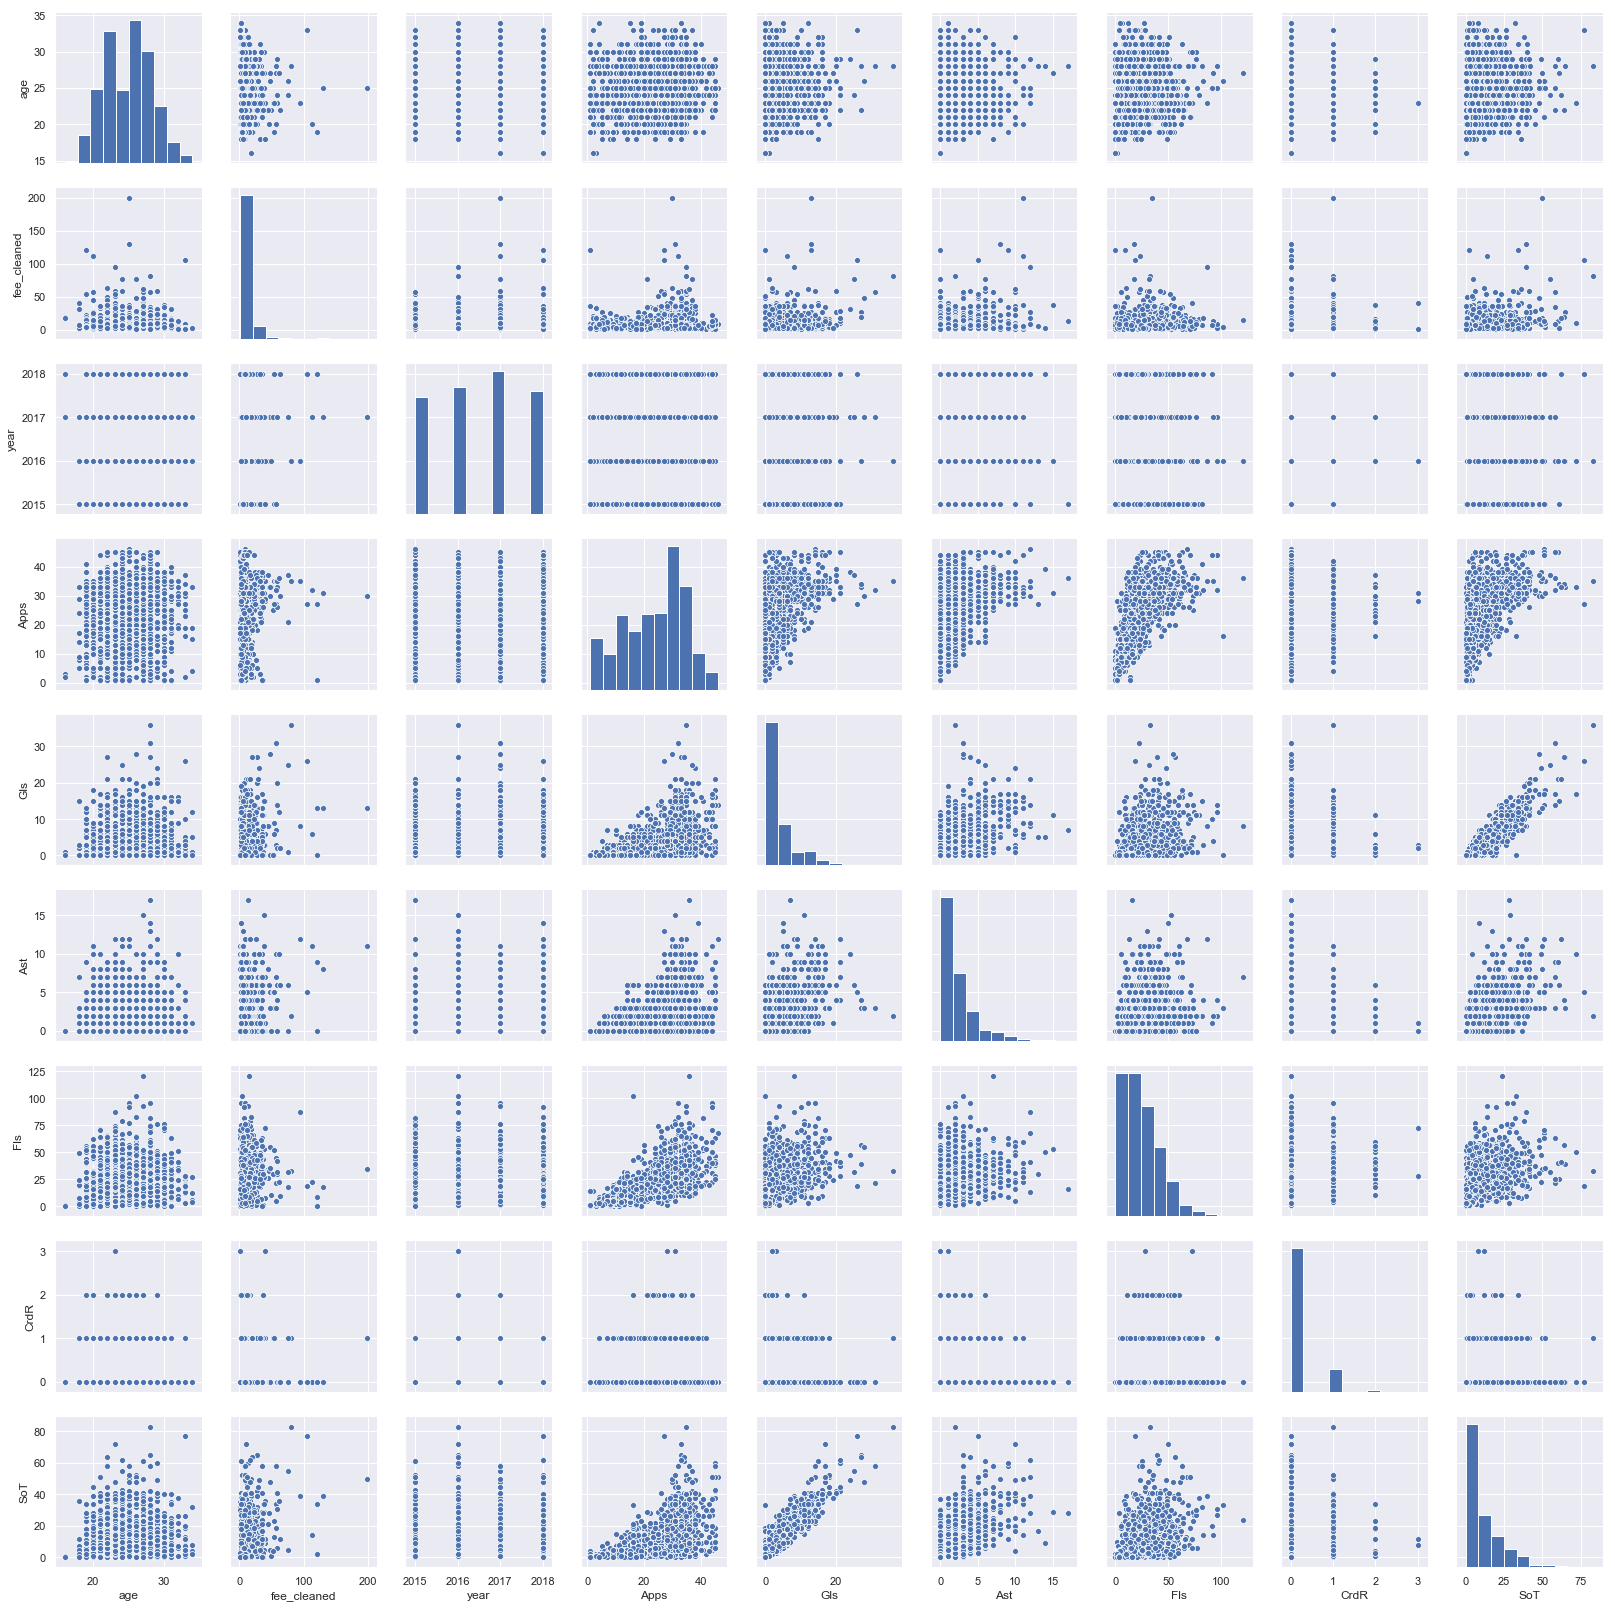

In [50]:
sns.pairplot(df_performance)

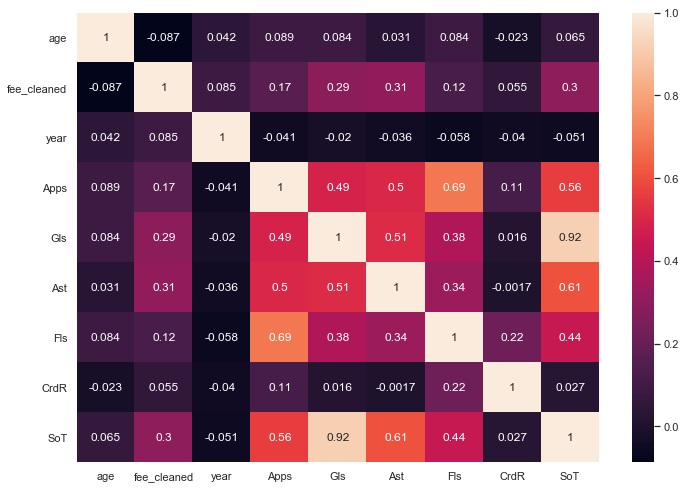

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_performance.corr(),annot=True)

In [55]:
df_performance.head()

,age,fee_cleaned,year,Apps,Gls,Ast,Fls,CrdR,SoT
Season_Transfer,,,,,,,,,
Davy_Pröpper 2015-16,23.0,4.05,2015.0,30.0,5.0,4.0,74.0,1.0,23.0
Ryad_Boudebouz 2015-16,25.0,1.53,2015.0,34.0,5.0,3.0,42.0,0.0,12.0
Kévin_Théophile-Catherine 2015-16,25.0,1.80,2015.0,31.0,0.0,0.0,43.0,0.0,1.0
Raúl_Jiménez 2015-16,24.0,19.80,2015.0,21.0,1.0,2.0,14.0,0.0,11.0
Karim_Rekik 2015-16,20.0,4.50,2015.0,26.0,2.0,2.0,27.0,0.0,2.0


In [58]:
kinds = ["scatter", "reg", "resid", "kde", "hex"]

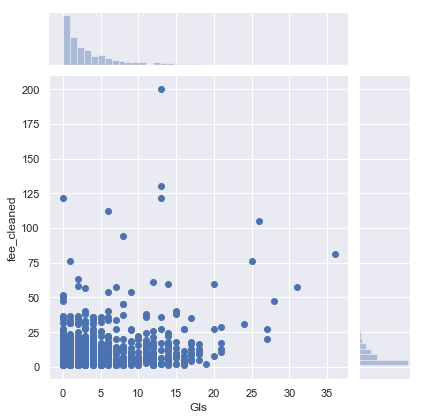

In [60]:
sns.jointplot("Gls","fee_cleaned",data=df_performance,kind="scatter")

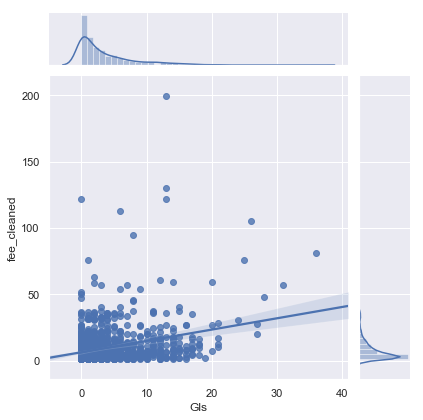

In [61]:
sns.jointplot("Gls","fee_cleaned",data=df_performance,kind="reg")

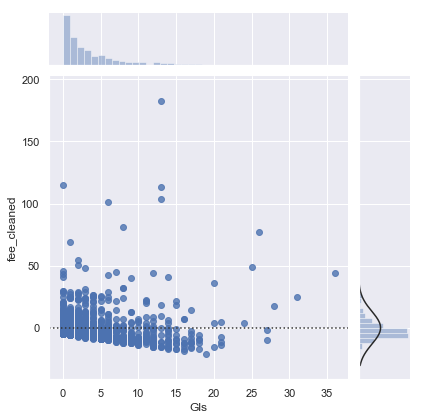

In [64]:
sns.jointplot("Gls","fee_cleaned",data=df_performance,kind="resid")

In [67]:
df_performance.columns

Index(['age', 'fee_cleaned', 'year', 'Apps', 'Gls', 'Ast', 'Fls', 'CrdR',
       'SoT'],
      dtype='object')

In [69]:
df_performance.groupby(["year"]).agg({"fee_cleaned": "mean", "age":"count"})

,fee_cleaned,age
year,,
2015.0,7.383700,273
2016.0,9.042054,297
2017.0,11.205958,334
2018.0,10.208854,288


In [70]:
df_fb = feather.read_dataframe("df_FBRefStatistics.feather")

/Users/sethweiland/anaconda3/envs/DS_env/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [71]:
df_fb

,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,...,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under,Season_Transfer
0,NED,DF,AZ Alkmaar,23,1991,34,34,0,3060,90,...,0.03,0.12,0.03,0.12,0.21,1.21,0.12,Jeffrey Gouweleeuw,Jeffrey_Gouweleeuw,Jeffrey_Gouweleeuw 2015-16
1,NED,GK,NAC Breda,33,1980,34,34,0,3060,90,...,0.00,0.00,0.00,0.00,0.00,0.00,0.09,Jelle ten Rouwelaar,Jelle_ten_Rouwelaar,Jelle_ten_Rouwelaar 2015-16
2,SWE,GK,Heerenveen,25,1989,34,34,0,3060,90,...,0.00,0.00,0.00,0.00,0.00,0.00,0.06,Kristoffer Nordfeldt,Kristoffer_Nordfeldt,Kristoffer_Nordfeldt 2015-16
3,BRA,DF,Groningen,26,1987,34,34,0,3060,90,...,0.09,0.15,0.09,0.15,0.21,1.38,0.12,Eric Botteghin,Eric_Botteghin,Eric_Botteghin 2015-16
4,NED,DF,Excelsior,25,1988,34,34,0,3055,90,...,0.03,0.06,0.00,0.03,0.15,1.12,0.12,Sander Fischer,Sander_Fischer,Sander_Fischer 2015-16
5,NED,MF,Groningen,26,1988,34,34,0,3016,89,...,0.45,0.63,0.42,0.60,1.82,0.75,0.00,Tjaronn Chery,Tjaronn_Chery,Tjaronn_Chery 2015-16
6,BEL,MF,Willem II,24,1989,34,34,0,3010,89,...,0.03,0.09,0.03,0.09,0.18,1.50,0.09,Stijn Wuytens,Stijn_Wuytens,Stijn_Wuytens 2015-16
7,NED,DF,Willem II,27,1987,34,34,0,2991,88,...,0.00,0.03,0.00,0.03,0.06,1.38,0.12,Jordens Peters,Jordens_Peters,Jordens_Peters 2015-16
8,NED,DF,Cambuur,27,1987,33,33,0,2970,90,...,0.03,0.06,0.03,0.06,0.24,1.15,0.21,Etiënne Reijnen,Etiënne_Reijnen,Etiënne_Reijnen 2015-16
9,NED,DFMF,ADO Den Haag,26,1987,33,33,0,2970,90,...,0.00,0.00,0.00,0.00,0.06,1.15,0.15,Aaron Meijers,Aaron_Meijers,Aaron_Meijers 2015-16


In [ ]:
pytrends = TrendReq(hl="en-US", tz=360)
pytrends.build_payload(kw_list=names[0],cat=0,timeframe='2015-08-15 2019-07-11',geo='',gprop='')
df_total = pytrends.interest_over_time()
list_dfs = []
for name in names[1:]:
    sleep_time = random.randint(0,4)
    time.sleep()
    pytrends.build_payload(kw_list=name,cat=0,timeframe='2015-08-15 2019-07-11',geo='',gprop='')
    df_trend = pytrends.interest_over_time()
    list_dfs.append(df_trend)
    df_total = df_total.merge(df_trend,right_index=True, left_index=True)
    print(df_total.shape)

# I want to look at google trends data using pytrends api 
### Objective: see if this can serve as a helpful proxy for player popularity, a teams primary goal is to win games, so mainly they're concerned with performance, yet they also strongly care about players who can put fans in the their seats and sell jerseys. Google Trends does not provide a raw score and instead provides a score relative to how often the player is normally searched. So I am going to look at the trend of google searches growth over the season before they were transferred for a given player

In [ ]:
df_full.columns

In [ ]:
names = np.unique(df_full['player_name'].values)

In [ ]:
names = [[x] for x in names]

In [ ]:
pytrends = TrendReq(hl="en-US", tz=360,retries=3,backoff_factor=0.1,timeout=(10,25))
pytrends.build_payload(kw_list=names[0],cat=0,timeframe='2014-08-15 2019-07-11',geo='',gprop='')
df_total = pytrends.interest_over_time()
list_dfs2 = []
list_dfs2.append(df_total)
for name in names[1:]:
    sleep_time = random.randint(0,4)
    time.sleep(sleep_time)
    pytrends.build_payload(kw_list=name,cat=0,timeframe='2014-08-15 2019-07-11',geo='',gprop='')
    df_trend = pytrends.interest_over_time()
    list_dfs2.append(df_trend)
    df_total = df_total.merge(df_trend,right_index=True, left_index=True)
    print(df_total.shape)
feather.write_dataframe(df_total, "py_trends.feather")   
    

In [ ]:
df_trendy = df_total.drop(["isPartial_x", "isPartial_y", "isPartial"],axis=1)

## Save for future use

In [ ]:
feather.write_dataframe(df_trendy, "df_g_trends.feather") 

In [ ]:
df_full['Season_Transfer']

In [ ]:
df_trendy = df_trendy.reset_index()
df_trendy.head(2)

In [ ]:
df_trendy['DateTime'] = pd.to_datetime(df_trendy['date'])

In [ ]:
df_trendy.head()

In [ ]:
df_trendy.groupby(df_trendy["DateTime"].dt.year).mean()

In [ ]:
df_trendy.head()

In [ ]:
rng_14_15_season = pd.date_range(start = "2014-08-17", end = "2015-06-14")
rng_15_16_season = pd.date_range(start = "2015-08-16", end = "2016-06-12")
rng_16_17_season = pd.date_range(start = "2016-08-14", end = "2017-06-11")
rng_17_18_season = pd.date_range(start = "2017-08-13", end = "2018-06-10") 



In [ ]:
def make_season_marker(row):
    if row in rng_14_15_season:
        return "2014-08-17 2015-06-14"
    if row in rng_15_16_season:
        return "2015-08-16 2016-06-12"
    if row in rng_16_17_season:
        return "2016-08-14 2017-06-11"
    if row in rng_17_18_season:
        return "2017-08-13 2018-06-10"

In [ ]:
df_trendy['season_range'] = df_trendy['date'].apply(make_season_marker)

In [ ]:
df_trendy['season_range'][0:10]

In [ ]:
#all n/a are google trend data for 2018-2019 season that 
#are not included in this model
df_trendy.dropna(inplace=True)

In [ ]:
df_group = df_trendy.groupby(['season_range']).mean()  

In [ ]:
df_group = df_group.reset_index().drop(['index'],axis=1)


In [ ]:
df_group.head()

In [ ]:
df_group = df_group.set_index("season_range")

In [ ]:
df_group_T = df_group.T

In [ ]:
df_group_T = df_group_T.reset_index()

In [ ]:
df_group_T.head()

In [ ]:
df_group_T['test_new'] = 0

In [ ]:
df_group_T.head(3)

In [ ]:
df_group_T['2014_15_name'] =  df_group_T['index'] + " " + '2014-08-17 2015-06-14'
df_group_T['']

In [ ]:
for column in df_group_T.columns[1:5]:
    for index,row in df_group_T.iterrows():
        print(index, row)

In [ ]:
for column in df_group_T.columns:
    for player in df_group_T['index']:
        df_group_T.loc[df_group_T['']] = df.iloc[row, 0] +  

In [ ]:
def add_season_dates(season):
    if season==2015.0:
        return "2014-08-17 2015-06-14"
    if season==2016.0:
        return "2015-08-16 2016-06-12"
    if season==2017.0:
        return "2016-08-14 2017-06-11"
    if season==2018.0:
        return "2017-08-13 2018-06-10"
        
        
        

In [ ]:
df_full['season_range'] = df_full['Player_name'] + " " +df_full['year'].apply(add_season_dates)


In [ ]:
df_full.head(50)